- PER: número de años necesarios para recuperar la inversión

        PER = Precio de compra / Ingresos anuales por alquiler


- Rentabilidad Bruta del Alquiler: Este ratio mide el rendimiento anual de la inversión en relación con el precio de compra

        Rentabilidad bruta (%) = (Ingresos anuales por alquiler / Precio de compra) × 100


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

sns.set_style('darkgrid')

/home/pdb/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
metrics = pd.read_csv('data/average_metrics.csv', index_col='Unnamed: 0')
metrics['evolution'] = metrics['evolution'].apply(eval)
metrics.head()

,distrito,tipo,venta/m2,alquiler/m2,PER,RB,difference,evolution
0.0,arganzuela,centro,5062.0,20.4,20.678105,4.836033,15.842071,"{'venta': [('Noviembre 2024', '5.062 €/m2'), (..."
NaN,barajas,centro,3901.0,14.6,22.265982,4.491156,17.774826,"{'venta': [('Noviembre 2024', '3.901 €/m2'), (..."
2.0,carabanchel,centro,2889.0,16.0,15.046875,6.645898,8.400977,"{'venta': [('Noviembre 2024', '2.889 €/m2'), (..."
3.0,centro,centro,6594.0,25.0,21.980000,4.549591,17.430409,"{'venta': [('Noviembre 2024', '6.594 €/m2'), (..."
4.0,chamartin,centro,6573.0,21.0,26.083333,3.833866,22.249468,"{'venta': [('Noviembre 2024', '6.573 €/m2'), (..."


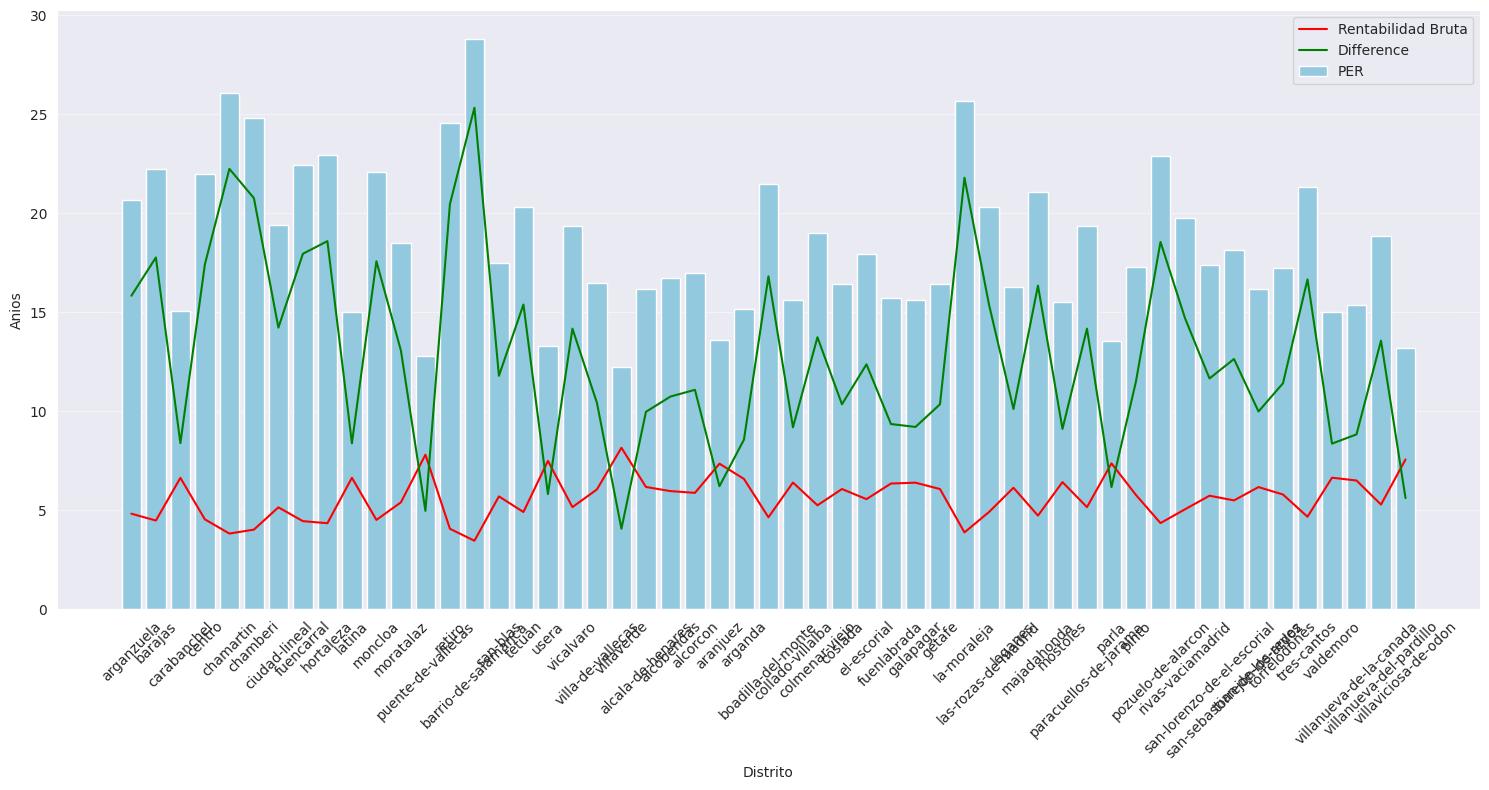

In [3]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.barplot(data=metrics, x=metrics['distrito'], y='PER', ax=ax, color='skyblue', label='PER')
sns.lineplot(data=metrics, x=metrics['distrito'], y='RB', ax=ax, color='red', label='Rentabilidad Bruta')
sns.lineplot(data=metrics, x=metrics['distrito'], y='difference', ax=ax, color='green', label='Difference')

ax.set_xlabel('Distrito')
ax.set_ylabel('Anios')

ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)
ax.tick_params(axis='x', rotation=45)
fig.tight_layout()
ax.legend()

plt.show()

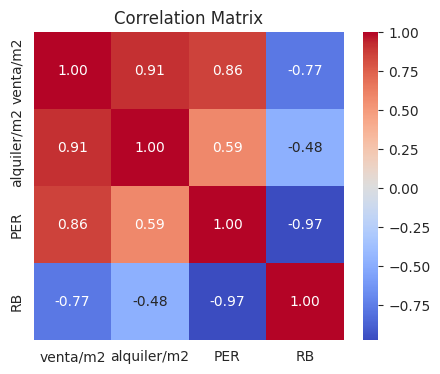

In [4]:
correlation_matrix = metrics[['venta/m2', 'alquiler/m2', 'PER', 'RB']].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [19]:
# Get evolution just from the last 10 years, from Noviembre 2024 to Noviembre 2014

aux = [i[0] for i in metrics.iloc[0]['evolution']['venta']]
idx = aux.index('Noviembre 2020')
months = aux[0:idx+1]
months.reverse()
print(months[0], months[-1])

Noviembre 2020 Noviembre 2024


In [20]:
def convert_dict(x):
    '''
    Converts evolution row to dict and makes all the districts have the same months.
    If we dont have data for that month, put it to zero. 
    '''
    
    evolution = x['evolution']
    result = {}
    for k in evolution: # k: venta/alquiler
        result[k] = []
        for _tuple in evolution[k]:
            
            price = _tuple[1].split(' ')[0]
            price = price.replace('.', '') if '.' in price else price.replace(',', '.')
            
            month = _tuple[0]
            
            if month not in months:            
                continue

            result[k].append(float(price) if price != 'nd' else 0)
    result['venta'].reverse()
    result['alquiler'].reverse()
    x['venta_evolution'] = result['venta']
    x['alquiler_evolution'] = result['alquiler']
    return x

def plot_evolution(distrito):
    item = metrics[metrics['distrito'] == distrito]
    
    fig, axs = plt.subplots(2, 1, figsize=(9, 4), sharex=True)
    fig.suptitle(distrito)

    venta_data = item['venta_evolution'].values[0]
    axs[0].plot(venta_data)
    axs[0].set_title('€/m2 Venta', fontsize=7)
    max_venta = max(venta_data)
    axs[0].text(len(venta_data) - 1, max_venta, f'max-{max_venta:.2f}', fontsize=7, color='blue', va='center', ha='left')
    min_venta = min(venta_data)
    axs[0].text(len(venta_data) - 1, min_venta, f'min-{min_venta:.2f}', fontsize=7, color='blue', va='center', ha='left')

    alquiler_data = item['alquiler_evolution'].values[0]
    axs[1].plot(alquiler_data, color='red')
    axs[1].set_title('€/m2 Alquiler', fontsize=7)
    max_alquiler = max(alquiler_data)
    axs[1].text(len(alquiler_data) - 1, max_alquiler, f'max-{max_alquiler:.2f}', fontsize=7, color='red', va='center', ha='left')
    min_alquiler = min(alquiler_data)
    axs[1].text(len(alquiler_data) - 1, min_alquiler, f'min-{min_alquiler:.2f}', fontsize=7, color='red', va='center', ha='left')

    step = 12
    axs[1].set_xticks(ticks=range(0, len(months), step), labels=months[::step], rotation=30, fontsize=7)
    plt.show()

In [21]:
metrics = metrics.apply(convert_dict, axis=1) 

# Conseguir tasa de evolucion en porcentaje

In [45]:
def calculate_average_anual_change(x):
    for k in ['venta', 'alquiler']:
        evol_year = {}
        for month, money in x['evolution'][k]:
            if month not in  months:
                break
            year = int(month.split(' ')[1])            
            if money == 'n.d.':
                continue
            if k == 'venta':
                money = money.split(' ')[0].replace('.', '')
            else:
                money = money.split(' ')[0].replace(',', '.')
            
            if year not in evol_year:
                evol_year[year] = []
            evol_year[year].append(float(money))
        
        for year, values in evol_year.items():
            evol_year[year] = sum(values) / len(values)

        
        final_year = 2024
        init_year = 2021
        tasa_evol_20_24 = ((evol_year[final_year] - evol_year[init_year]) / evol_year[init_year]) * 100

        tasas = []
        for year in list(evol_year.keys())[:-1]:
            tasa = ((evol_year[year] - evol_year[year - 1]) / evol_year[year - 1]) * 100
            tasas.append(tasa)
        average_anual = sum(tasas) / len(tasas)
        
        x[f'change_2014_2024_{k}'] = average_anual
        x[f'change_{init_year}_{final_year}_{k}'] = tasa_evol_20_24
    return x

In [46]:
evolution = metrics.apply(calculate_average_anual_change, axis=1)

In [47]:
evolution = evolution[['distrito', 'change_2014_2024_venta', 'change_2014_2024_alquiler', 'change_2021_2024_venta', 'change_2021_2024_alquiler']].set_index('distrito')

In [48]:
evolution.head()

,change_2014_2024_venta,change_2014_2024_alquiler,change_2021_2024_venta,change_2021_2024_alquiler
distrito,,,,
arganzuela,5.147023,7.719062,19.490819,36.268388
barajas,3.814260,6.462132,12.814196,26.278098
carabanchel,5.847685,7.292907,26.266077,33.562868
centro,7.303501,9.207885,31.455366,44.344205
chamartin,5.749366,7.053207,23.559128,33.573357


In [49]:
evolution.to_csv('evolution.csv')

In [9]:
# Calculate normal change and cumulative change for each district
def calculate_change(x):
    keys = ['venta', 'alquiler']
    for k in keys:
        venta = x[f'{k}_evolution']
        x[f'{k}_change'] = np.diff(np.array(venta))
        x[f'{k}_avg_change'] = np.average(x[f'{k}_change'])
    return x

In [10]:
metrics = metrics.apply(calculate_change, axis=1)

## Top 5 with more change in venta/alquiler

In [12]:
keys = ['venta', 'alquiler']
for k in keys:
    print(k, '\n')
    distritos = metrics.nlargest(5, f'{k}_avg_change')['distrito'].tolist()
    cols = ['distrito', 'PER', 'RB', 'venta_avg_change', 'alquiler_avg_change']
    print(metrics[metrics['distrito'].isin(distritos)][cols])

venta 

                 distrito        PER        RB  venta_avg_change  \
3.0                centro  21.980000  4.549591         27.225000   
4.0             chamartin  26.083333  3.833866         22.383333   
5.0              chamberi  24.802905  4.031786         29.975000   
13.0               retiro  24.546512  4.073899         27.025000   
14.0  barrio-de-salamanca  28.806667  3.471419         37.575000   

      alquiler_avg_change  
3.0              0.095000  
4.0              0.070833  
5.0              0.087500  
13.0             0.079167  
14.0             0.091667  
alquiler 

                 distrito        PER        RB  venta_avg_change  \
0.0            arganzuela  20.678105  4.836033         20.033333   
3.0                centro  21.980000  4.549591         27.225000   
5.0              chamberi  24.802905  4.031786         29.975000   
13.0               retiro  24.546512  4.073899         27.025000   
14.0  barrio-de-salamanca  28.806667  3.471419         37.575000

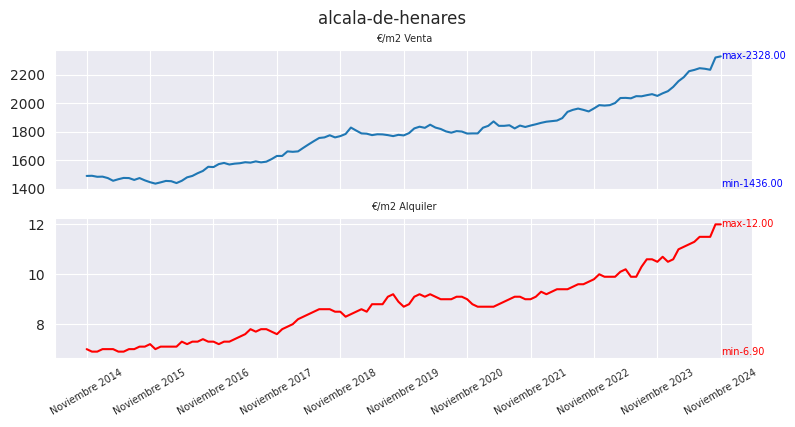

In [11]:
plot_evolution('alcala-de-henares')

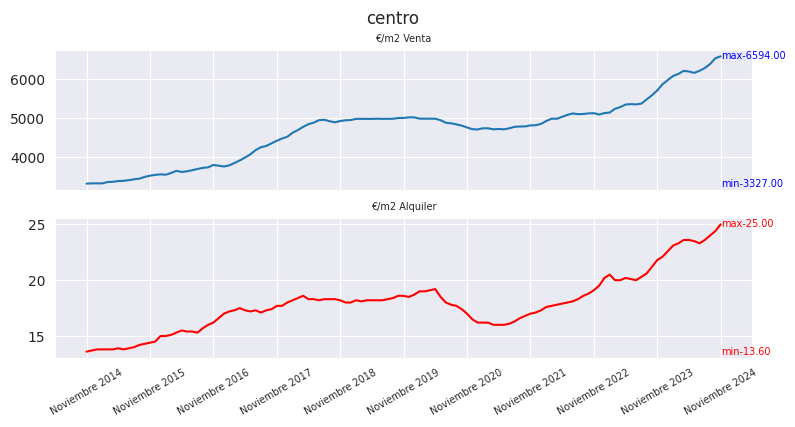

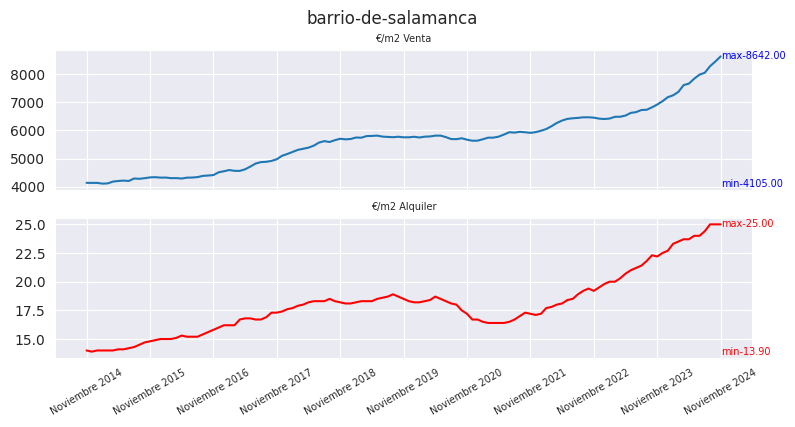

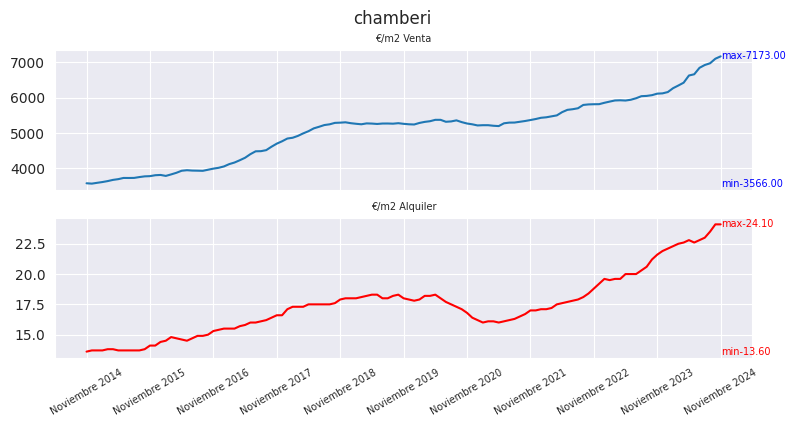

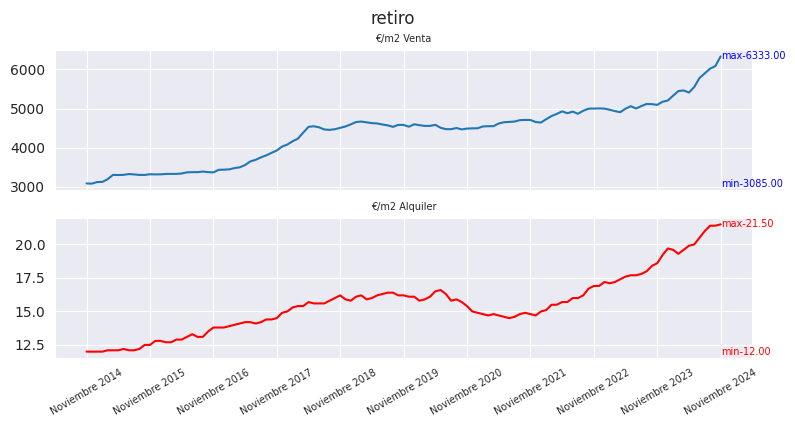

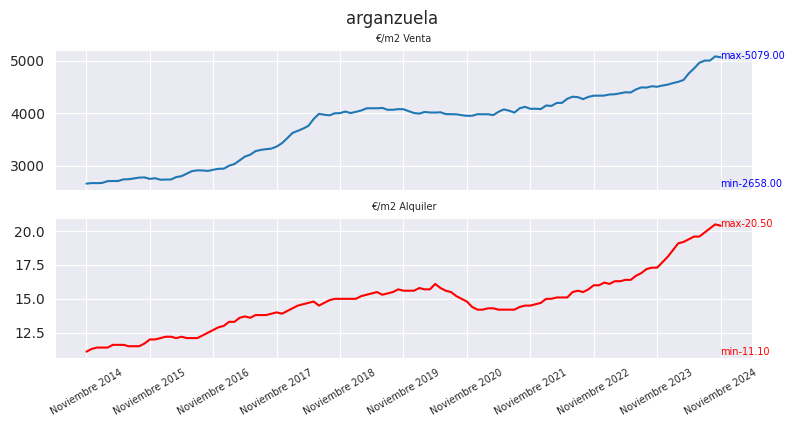

In [13]:
for distrito in distritos:
    plot_evolution(distrito)

## Top 5 with less change in venta/alquiler

In [14]:
keys = ['venta', 'alquiler']
for k in keys:
    print(k, '\n')
    distritos = metrics.nsmallest(5, f'{k}_avg_change')['distrito'].tolist()
    cols = ['distrito', 'PER', 'RB', 'venta_avg_change', 'alquiler_avg_change']
    print(metrics[metrics['distrito'].isin(distritos)][cols])
    break

venta 

        distrito        PER        RB  venta_avg_change  alquiler_avg_change
27.0    aranjuez  13.584906  7.361111          3.716667             0.044167
45.0     coslada  16.443089  6.081582          6.075000             0.040833
79.0       parla  13.554572  7.377584          5.683333             0.047500
82.0       pinto  17.299383  5.780553          5.075000             0.036667
102.0  valdemoro  15.029240  6.653696          5.400000             0.045833


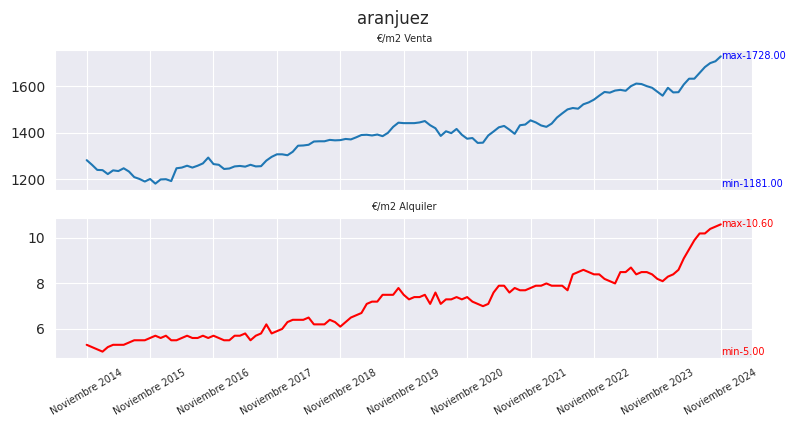

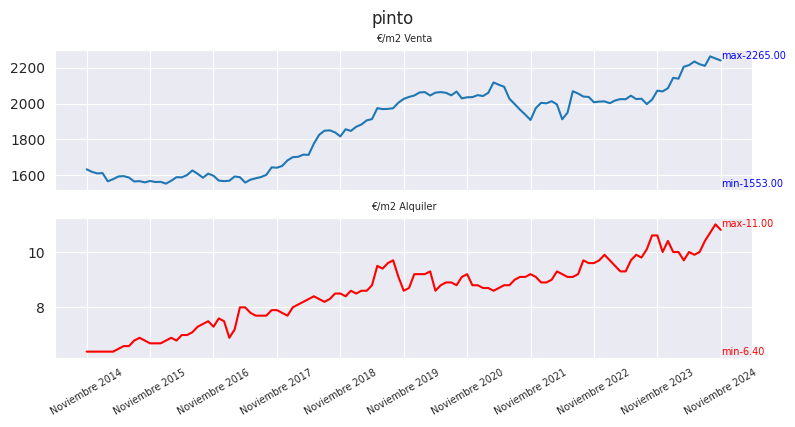

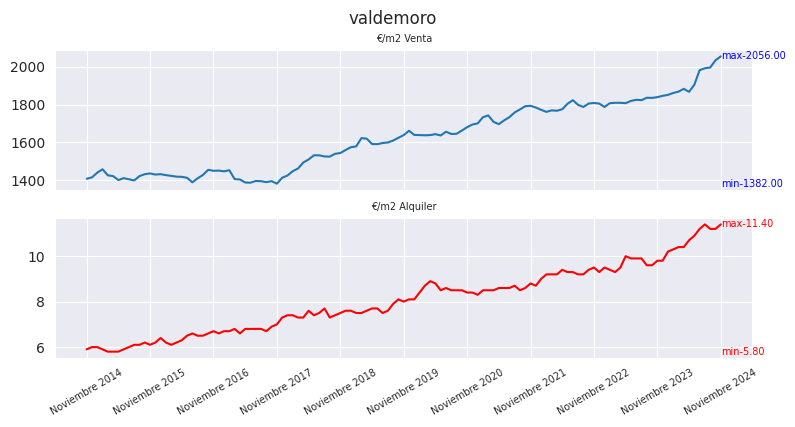

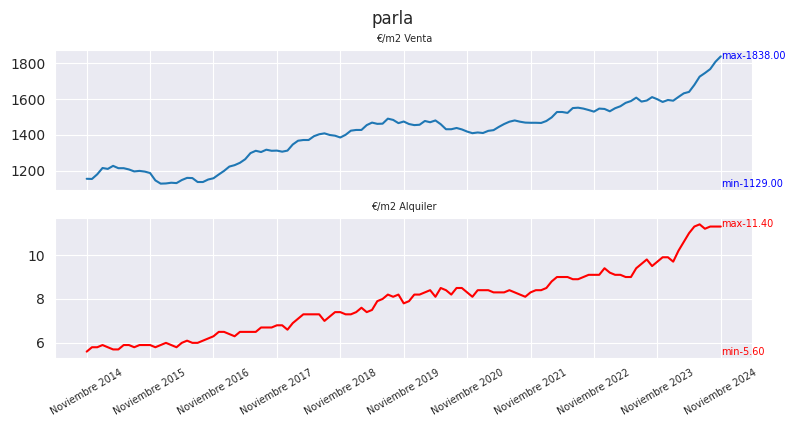

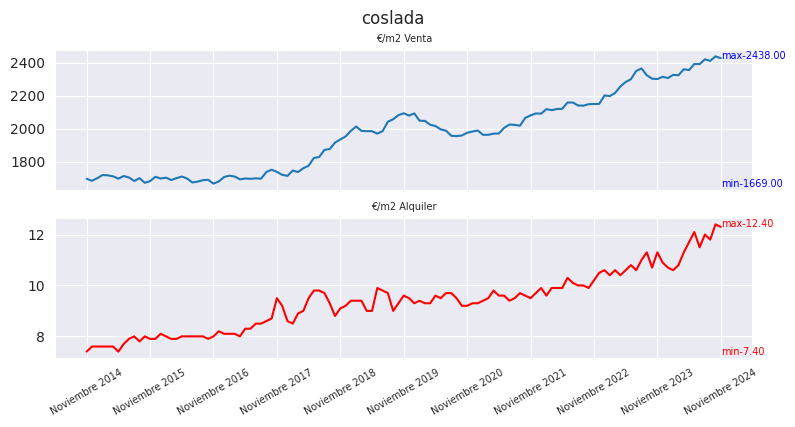

In [15]:
for distrito in distritos:
    plot_evolution(distrito)

## If all flats are 100m2

In [49]:
venta_evolution = metrics[['distrito', 'venta_evolution']].set_index('distrito')['venta_evolution'].to_dict()
alquiler_evolution = metrics[['distrito', 'alquiler_evolution']].set_index('distrito')['alquiler_evolution'].to_dict()

In [101]:
df = metrics[['distrito', 'tipo', 'venta/m2', 'alquiler/m2', 'venta_avg_change', 'alquiler_avg_change']].copy()

distritos = df['distrito'].tolist()

df['size'] = 30
sizes = [50, 70, 100, 120] # average sizes

new_rows = []
for distrito in distritos:
    for size in sizes:
        row_copy = df.loc[df['distrito'] == distrito].copy()
        row_copy['size'] = size
        new_rows.append(row_copy)

df = pd.concat([df] + new_rows, ignore_index=True)

df['venta'] = df['venta/m2'] * df['size']
df['alquiler'] = df['alquiler/m2'] * df['size']

df['PER'] = df['venta'] / (df['alquiler'] * 12)
df['rentabilidad_anual'] = ((df['alquiler'] * 12) / df['venta']) * 100

df['evolution_venta_year'] = df['venta_avg_change'] / len(months)

# TODO: calcular PER ajustado al alquiler

# Cuando acabe de pagar el precio de compra con el alquiler, por cuanto estimo que la vendere? 
df['revalorizacion'] = df['venta'] * (df['evolution_venta_year'] * df['PER'])

# Normalize the columns using Min-Max scaling
scaler = MinMaxScaler()
df['normalized_revalorizacion'] = scaler.fit_transform(df[['revalorizacion']])
df['normalized_rentabilidad_anual'] = scaler.fit_transform(df[['rentabilidad_anual']])
df['normalized_PER'] = scaler.fit_transform(1 / df[['PER']])

df.head()

,distrito,tipo,venta/m2,alquiler/m2,venta_avg_change,alquiler_avg_change,size,venta,alquiler,PER,rentabilidad_anual,evolution_venta_year,revalorizacion,normalized_revalorizacion,normalized_rentabilidad_anual,normalized_PER
0,arganzuela,centro,5062.0,20.4,20.033333,0.077500,30,151860.0,612.0,20.678105,4.836033,0.165565,519902.576703,0.053837,0.290619,0.290619
1,barajas,centro,3901.0,14.6,10.783333,0.042500,30,117030.0,438.0,22.265982,4.491156,0.089118,232223.792572,0.022754,0.217171,0.217171
2,carabanchel,centro,2889.0,16.0,10.541667,0.062500,30,86670.0,480.0,15.046875,6.645898,0.087121,113615.875355,0.009939,0.676061,0.676061
3,centro,centro,6594.0,25.0,27.225000,0.095000,30,197820.0,750.0,21.980000,4.549591,0.225000,978318.810000,0.103367,0.229616,0.229616
4,chamartin,centro,6573.0,21.0,22.383333,0.070833,30,197190.0,630.0,26.083333,3.833866,0.184986,951453.067149,0.100464,0.077189,0.077189


In [150]:
input_money = 500000 # I have this money

weight_valorizacion = 0.3
weight_rent_anual = 0.4
weight_per = 0.2
#weight_prestamo = 0.4

In [151]:
df['prestamo'] = df['venta'].apply(lambda x: x - input_money) # keep just the ones with 0 or positive prestamo

filtered = df[df['prestamo'] > 0].copy()

filtered['normalized_prestamo'] = scaler.fit_transform(1 / filtered[['prestamo']])
filtered['score'] = (weight_valorizacion * filtered['normalized_revalorizacion'] 
                     + weight_rent_anual * filtered['normalized_rentabilidad_anual'] 
                     + weight_per * filtered['normalized_PER']
                     #+ weight_prestamo * filtered['normalized_prestamo']
                    )

cols = ['tipo', 'venta/m2', 'alquiler/m2','venta_avg_change', 'alquiler_avg_change', 'evolution_venta_year', 'normalized_revalorizacion', 'normalized_rentabilidad_anual', 'normalized_prestamo', 'normalized_PER']
filtered = filtered.drop(columns=cols)
filtered = filtered.sort_values(by=['prestamo'])
filtered.head()

,distrito,size,venta,alquiler,PER,rentabilidad_anual,revalorizacion,prestamo,score
74,chamberi,70,502110.0,1687.0,24.802905,4.031786,3.085143e+06,2110.0,0.204005
55,arganzuela,100,506200.0,2040.0,20.678105,4.836033,1.733009e+06,6200.0,0.248335
95,moncloa,100,514700.0,1940.0,22.109107,4.523023,1.651290e+06,14700.0,0.204806
84,fuencarral,120,516600.0,1920.0,22.421875,4.459930,1.250852e+06,16600.0,0.179438
88,hortaleza,120,538800.0,1956.0,22.955010,4.356347,1.412287e+06,38800.0,0.173179


In [152]:
filtered.nlargest(50, 'score')

,distrito,size,venta,alquiler,PER,rentabilidad_anual,revalorizacion,prestamo,score
112,salamanca,120,1037040.0,3000.0,28.806667,3.471419,9.276884e+06,537040.0,0.400000
111,salamanca,100,864200.0,2500.0,28.806667,3.471419,7.730737e+06,364200.0,0.333178
68,centro,120,791280.0,3000.0,21.980000,4.549591,3.913275e+06,291280.0,0.305961
76,chamberi,120,860760.0,2892.0,24.802905,4.031786,5.288816e+06,360760.0,0.299245
67,centro,100,659400.0,2500.0,21.980000,4.549591,3.261063e+06,159400.0,0.277773
120,tetuan,120,594000.0,2436.0,20.320197,4.921212,1.951847e+06,94000.0,0.268677
56,arganzuela,120,607440.0,2448.0,20.678105,4.836033,2.079610e+06,107440.0,0.263314
75,chamberi,100,717300.0,2410.0,24.802905,4.031786,4.407346e+06,217300.0,0.261149
108,retiro,120,759960.0,2580.0,24.546512,4.073899,4.166399e+06,259960.0,0.256117
55,arganzuela,100,506200.0,2040.0,20.678105,4.836033,1.733009e+06,6200.0,0.248335


# Representar la evolucion del €/m2 de venta y alquiler

## Top 6 con menor PER, menor numero de anios en recuperar la inversión

In [29]:
districts = metrics.nsmallest(6, 'PER')['distrito'].tolist()

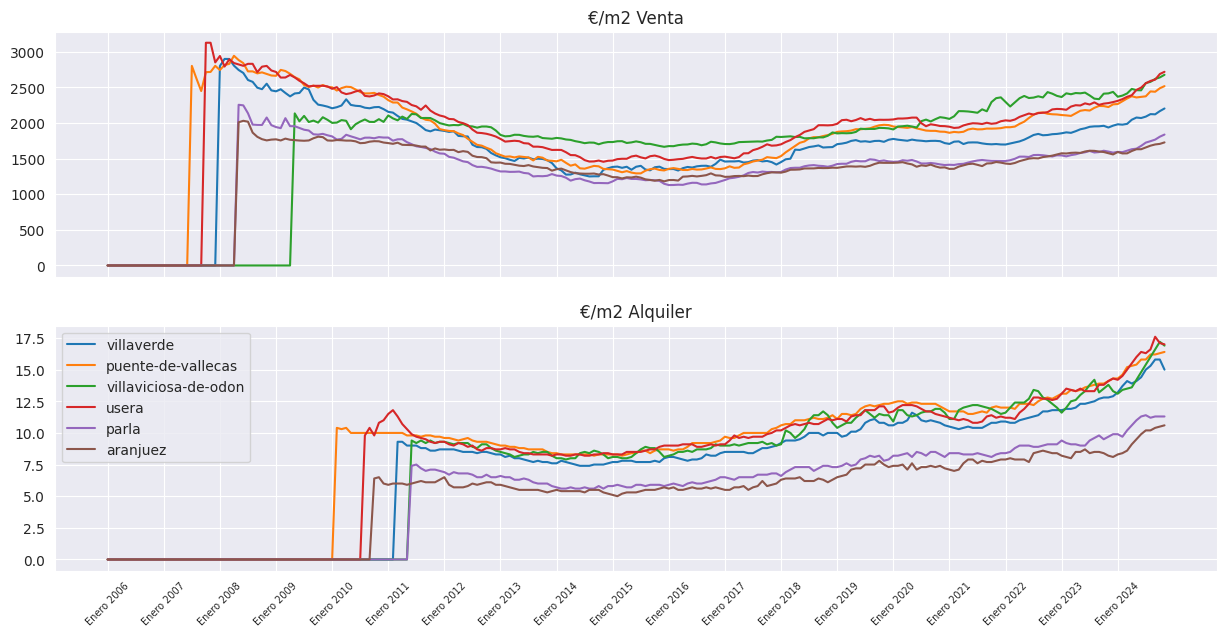

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(15, 7), sharex=True)
axs[0].set_title('€/m2 Venta')
axs[1].set_title('€/m2 Alquiler')

for distrito in districts:
    
    venta = [_evolution[distrito]['venta'][m] if m in _evolution[distrito]['venta'] else 0 for m in meses]
    alquiler = [_evolution[distrito]['alquiler'][m] if m in _evolution[distrito]['alquiler'] else 0 for m in meses]

    axs[0].plot(meses, venta, label=distrito)
    axs[1].plot(meses, alquiler, label=distrito)

    step = 12
    axs[1].set_xticks(ticks=range(0, len(meses), step), labels=meses[::step], rotation=45, fontsize=7)
plt.legend()
plt.show()

## Top 5 con mayor PER, mayor numero de anios en recuperar la inversión

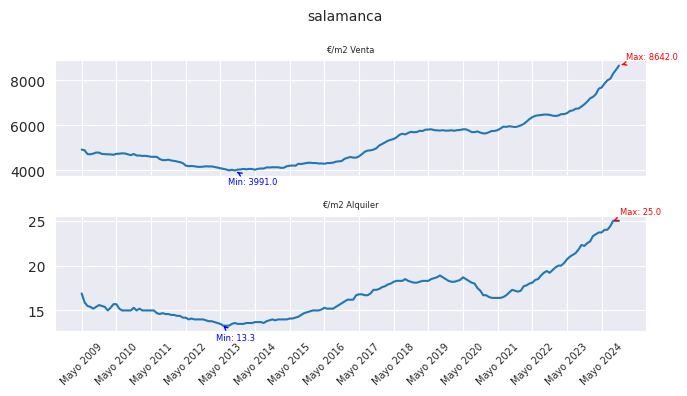

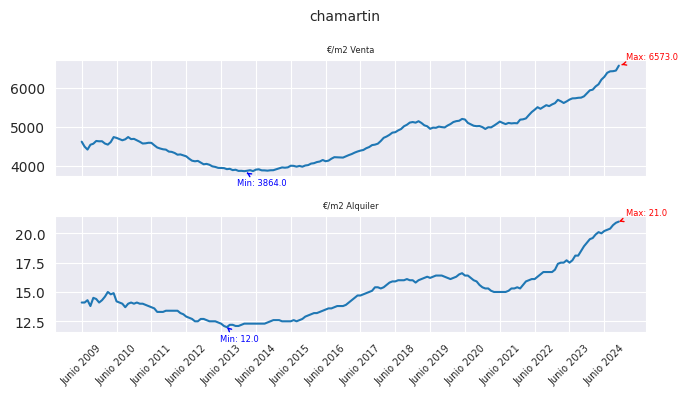

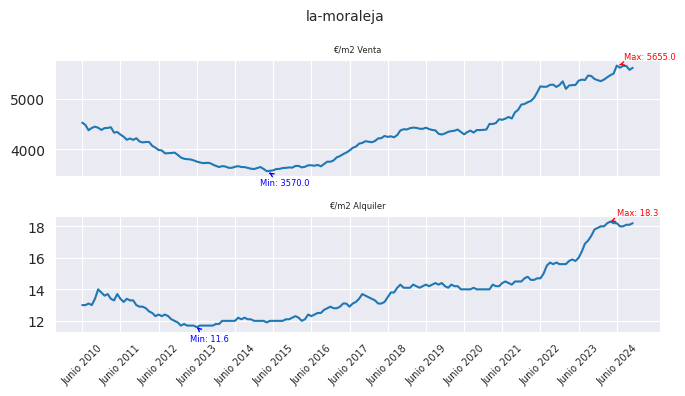

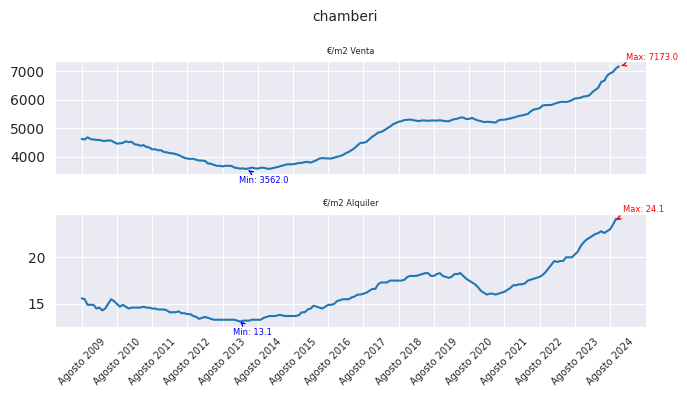

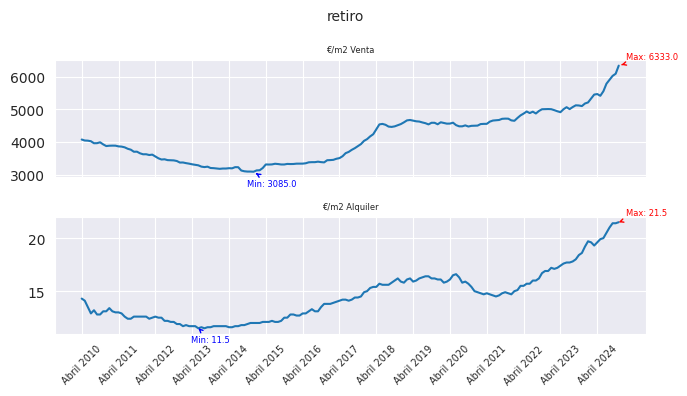

In [57]:
for distrito in metrics.nlargest(5, 'PER')['distrito'].tolist():
    item = metrics[metrics['distrito'] == distrito]
    plot_evolution(item)

## Top 5 con menor Rentabilidad Bruta

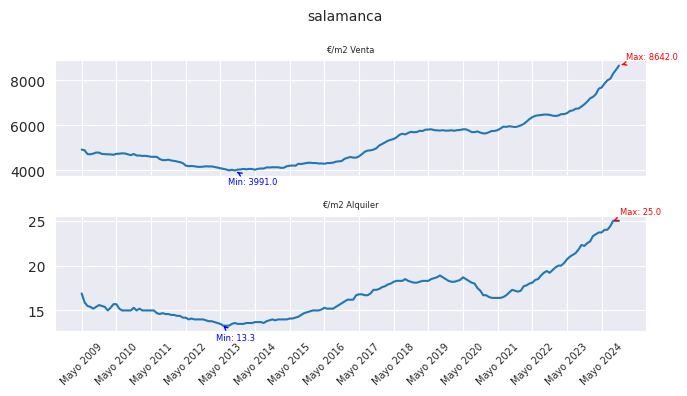

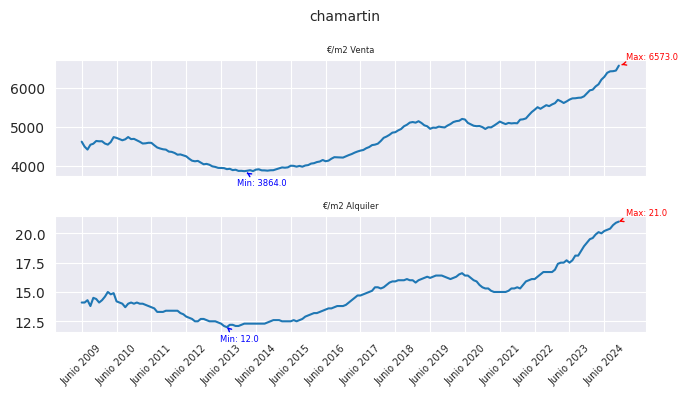

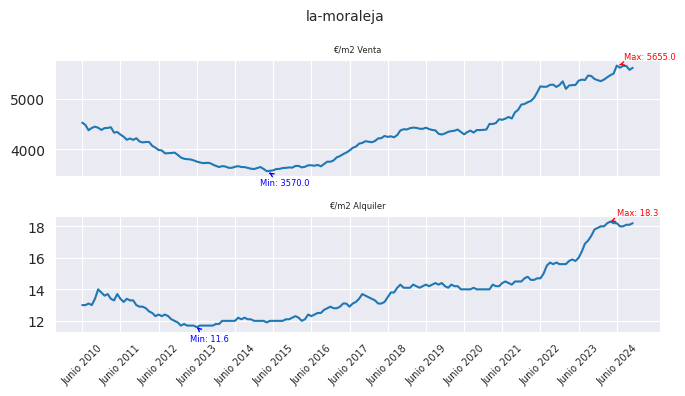

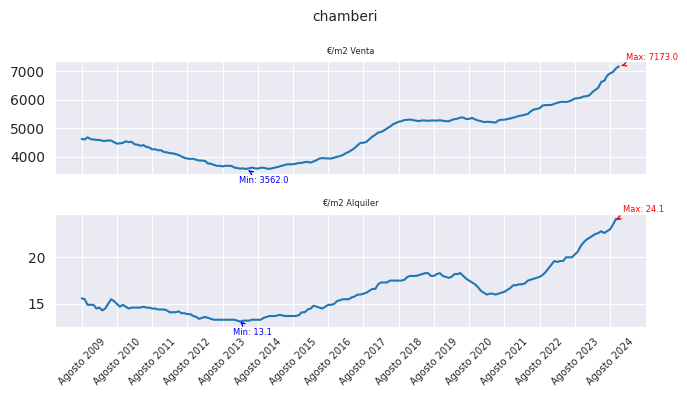

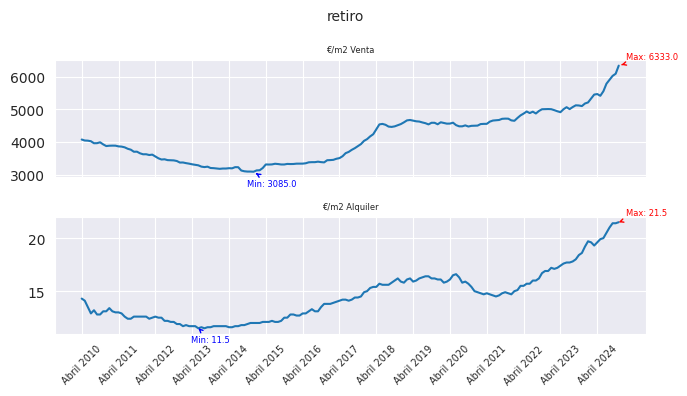

In [58]:
for distrito in metrics.nsmallest(5, 'RB')['distrito'].tolist():
    item = metrics[metrics['distrito'] == distrito]
    plot_evolution(item)

## Top 5 con mayor Rentabilidad Bruta

In [ ]:
for distrito in metrics.nlargest(5, 'RB')['distrito'].tolist():
    item = metrics[metrics['distrito'] == distrito]
    plot_evolution(item)

In [ ]:
distrito = 'centro'

_dict = metrics[metrics['distrito'] == distrito]['evolution'].values[0]

venta = [float(i[1].split(' ')[0].replace('.', '')) for i in _dict['venta'] if i[1] != 'n.d.']
alquiler = [float(i[1].split(' ')[0].replace(',', '.')) for i in _dict['alquiler'] if i[1] != 'n.d.']

In [49]:
venta = [(i[0], float(i[1].split(' ')[0].replace('.', ''))) for i in _dict['venta'] if i[1] != 'n.d.']
meses_v, venta = zip(*venta)

alquiler = [(i[0], float(i[1].split(' ')[0].replace(',', '.'))) for i in _dict['alquiler'] if i[1] != 'n.d.']
meses_a, alquiler = zip(*alquiler)

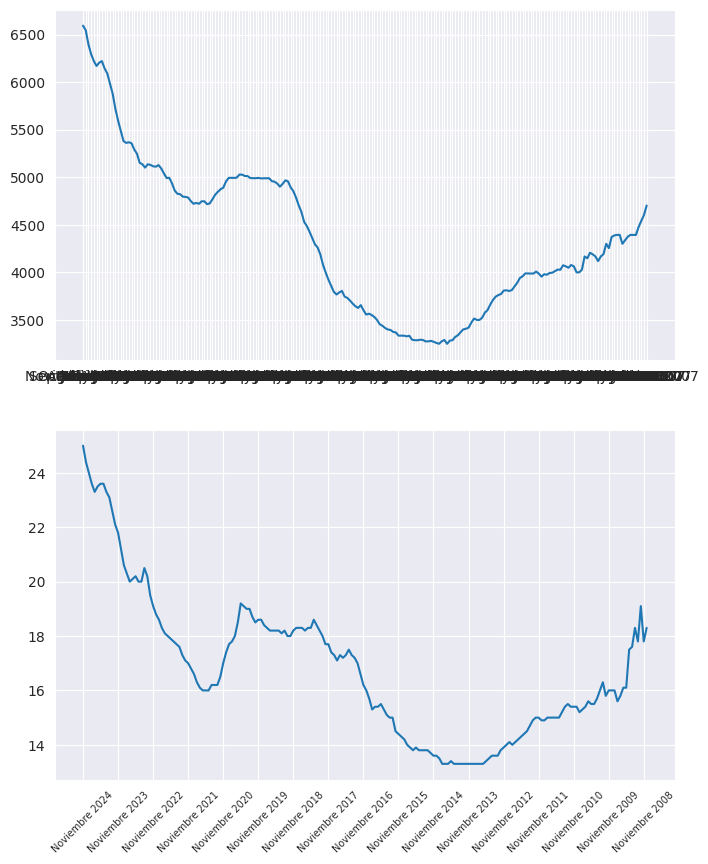

In [53]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

ax[0].plot(meses_v, venta)
ax[1].plot(meses_a, alquiler)

step = 12
ax[1].set_xticks(ticks=range(0, len(meses_a), step), labels=meses_a[::step], rotation=45, fontsize=7)